In [2]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
plt.rcParams.update({'figure.max_open_warning': 0})
from astropy.io import fits
import pymc3 as pm
import pandas as pd
import exoplanet as xo
from parameters import *

In [3]:
hostname = 'K2-167'
TIC = 69747919

tess_offset, k2_offset = define_offsets()

period, t0, dur, depth, impact_param, r_planet, r_star = get_params(hostname)
period_guess, t0, dur, depth, impact_param, r_planet, r_star = generate_inputs(period, t0, dur, depth, impact_param, r_planet, r_star)


print(period_guess)

9.977481


In [6]:
print(period, t0, dur, depth, impact_param, r_planet, r_star)

9.977481 2456979.93678 nan nan nan 0.252 1.83
9.977481 2456979.93678 nan nan nan 0.252 1.83


/Users/charlotte/anaconda3/lib/python3.5/site-packages/lightkurve/interact.py:408: LightkurveWarning: interact() requires Bokeh version 1.0 or later
  warnings.warn("interact() requires Bokeh version 1.0 or later", LightkurveWarning)


TypeError: show() got an unexpected keyword argument 'notebook_url'

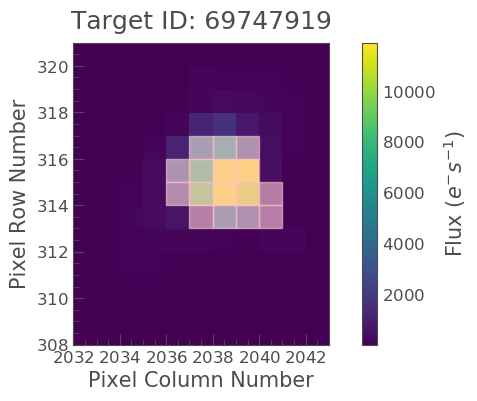

In [4]:
# known transit times for target converted to TESS time
# this will be automated eventually
t1_tess = 2458356.835732790 - 2457000
t2_tess = 2458366.812702527 - 2457000
t3_tess = 2458376.790203780 - 2457000

# plot the TPF for the target to make sure the aperture looks ok
tpf_tess = lk.search_targetpixelfile(TIC, mission='TESS').download()
tpf_tess.plot(aperture_mask=tpf_tess.pipeline_mask)
#tpf_tess.interact()

# run PLD on light curve to remove noise
def get_transit_mask(t, transit_time, period_guess, duration=0.2):
    hp = 0.5*period_guess
    return np.abs((t-transit_time+hp) % period_guess - hp) < 0.5*duration

mask = np.ones_like(tpf_tess.time, dtype=bool)
mask &= get_transit_mask(tpf_tess.time, t1_tess, period_guess)
corrector = lk.PLDCorrector(tpf_tess)
lc_tess = corrector.correct(cadence_mask=~mask, use_gp=False)
lc_tess = lc_tess.remove_outliers(sigma = 6).remove_outliers(sigma=6)

# plot light curve without PLD corrections for comparison
lc2_tess = tpf_tess.to_lightcurve(aperture_mask=tpf_tess.pipeline_mask)
clipped_lc2_tess = lc2_tess.remove_outliers(sigma=6).flatten()

ax = lc_tess.scatter(s=0.1)
ax = clipped_lc2_tess.scatter(s=0.1)

In [ ]:
# plot transit times predicted by K2 on the TESS light curve
ax = lc_tess.scatter(s=0.1)
plt.xlim(1353,1383)

x_tess = []
x_tess.append(t1_tess)
x_tess.append(t2_tess)
x_tess.append(t3_tess)
print(x_tess)

for i in x_tess:
    plt.axvline(x=i, color='hotpink', alpha=0.4, linewidth = 6)
    
plt.title('K2-167 Light Curve') 
plt.savefig('k2-167b.png')
plt.show()

In [ ]:
# fold data using period determined by K2 to generate phase curve with TESS data
fold = lc_tess.fold(period_guess, t0 = t1_tess)
ax = fold.scatter(s=0.1)

In [ ]:
# format data for use in xo
norm_tess = lc_tess.normalize()
x_tess = np.ascontiguousarray(norm_tess.time, dtype=np.float64)
y_tess = np.ascontiguousarray(norm_tess.flux, dtype=np.float64)
yerr_tess = np.ascontiguousarray(norm_tess.flux_err, dtype=np.float64)

In [ ]:
# initial fit of model parameters using TESS data
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1, sd=1.0)

    # The time of a reference transit for the planet (including a manually determined offset)
    t0 = pm.Normal("t0", mu=t1_tess + 0.05, sd=1.0)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u")

    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.001, max_radius=0.1,
        testval_r=.01,
        testval_b=0.5
    )

    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x_tess)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr_tess, observed=y_tess)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln_tess = model.test_point
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [t0])
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [mean, model.rb])
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [logP, t0])
    map_soln_tess = xo.optimize(start=map_soln_tess)

In [ ]:
# display initial model results
print(map_soln_tess)

In [ ]:
# plot estimated transit model over folded data
x_fold = x_tess % period_guess
inds = np.argsort(x_fold)
plt.plot(x_fold, y_tess, ".", ms=3, alpha=0.3)
with model:
    plt.plot(x_fold[inds], xo.utils.eval_in_model(light_curve)[inds])
    plt.plot(x_fold[inds], xo.utils.eval_in_model(light_curve, map_soln_tess)[inds])

In [ ]:
# plot model transits over TESS data
plt.plot(x_tess, y_tess)
plt.plot(x_tess, map_soln_tess["light_curves"] + map_soln_tess["mean"])

In [ ]:
# run MCMC to determine planet parameters
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln_tess, step_kwargs=dict(target_accept=0.9))
    trace_tess = sampler.sample(draws=3000)

In [ ]:
# display results
pm.summary(trace_tess, varnames=["period", "t0", "r", "b", "u", "mean"])

In [ ]:
# known transit time during K2 observation
t1_k2 = 2156.9142610001054

In [ ]:
# read in K2 SFF data
hdu = fits.open('./c03/205900000/04628/hlsp_k2sff_k2_lightcurve_205904628-c03_kepler_v1_llc.fits')
print(hdu[1].columns)
flux = hdu[1].data['FCOR']
time = hdu[1].data['T']

# plot uncorrected light curve
plt.plot(time,flux)

# correct light curve
lc_k2 = lk.LightCurve(flux=flux, time=time)
clipped_lc_k2 = lc_k2.flatten().remove_outliers(sigma=6).remove_outliers(sigma=6)
y_err_k2 = np.std(clipped_lc_k2.flux[0:100]) * np.ones(len(clipped_lc_k2.flux))

# plot corrected light curve 
ax = clipped_lc_k2.scatter(s=0.1)

In [ ]:
# plot phase curve
fold_k2 = clipped_lc_k2.fold(9.977481)
ax = fold_k2.scatter(s=0.1)

In [ ]:
# format data for input into xo
norm_k2 = clipped_lc_k2.normalize()
x_k2 = np.ascontiguousarray(norm_k2.time, dtype=np.float64)
y_k2 = np.ascontiguousarray(norm_k2.flux, dtype=np.float64)
yerr_k2 = np.ascontiguousarray(y_err_k2, dtype=np.float64)

In [ ]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t1_k2, sd=1.0)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u")

    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.0001, max_radius=0.1,
        testval_r=.001,
        testval_b=0.5
    )

    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x_k2)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr_k2, observed=y_k2)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln_k2 = model.test_point
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [t0])
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [mean, model.rb])
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [logP, t0])
    map_soln_k2 = xo.optimize(start=map_soln_k2)

In [ ]:
# print initial model results
print(map_soln_k2)

In [ ]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln_k2, step_kwargs=dict(target_accept=0.9))
    trace_k2 = sampler.sample(draws=3000)

In [ ]:
# print planet parameters determined using K2 data
pm.summary(trace_k2, varnames=["period", "t0", "r", "b", "u", "mean"])

In [ ]:
tess_period = trace_tess["period"][0]
k2_period_xo = trace_k2["period"][0]

print(tess_period, k2_period_xo)
print(f'The difference between TESS and K2 periods each determined with xo is {(tess_period - k2_period_xo)*24*60} minutes')
print(f'The difference between TESS and the known period value from the literature is {(tess_period - period_guess)*24*60} minutes')
print(f'The difference between the K2 period determined with xo and the known period value from the literature is {(k2_period_xo - period_guess)*24*60} minutes')

In [ ]:
### plot results from TESS ###

# Get the posterior median orbital parameters
p = np.median(trace_tess["period"][:])
t0 = np.median(trace_tess["t0"][:])

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other = np.median(trace_tess["mean"])

# Plot the folded data
x_fold = (x_tess - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_tess - other, yerr=yerr_tess, fmt=".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace_tess["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.4f} +/- {1:.4f} d".format(
    np.mean(trace_tess["period"][:]), np.std(trace_tess["period"][:]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.title("K2-167 b, TESS Data");
plt.xlim(-0.3, 0.3)

In [ ]:
### plot results from K2 ###

# Get the posterior median orbital parameters
p = np.median(trace_k2["period"][:])
t0 = np.median(trace_k2["t0"][:])

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other = np.median(trace_k2["mean"])

# Plot the folded data
x_fold = (x_k2 - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_k2 - other, yerr=yerr_k2, fmt=".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace_k2["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.4f} +/- {1:.4f} d".format(
    np.mean(trace_k2["period"][:]), np.std(trace_k2["period"][:]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.title("K2-167 b, K2 Data");
plt.xlim(-0.3, 0.3)